In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
dataset_path = "../input/sentiment140/training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/sentiment140/training.1600000.processed.noemoticon.csv


In [6]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
decode_map = {0: "NEGATIVE", 
              2: "NEUTRAL", 
              4: "POSITIVE"}


def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 632 ms, sys: 20.1 ms, total: 652 ms
Wall time: 653 ms


In [9]:
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Pre-Processing the Text column**

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [13]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 53.7 s, sys: 166 ms, total: 53.9 s
Wall time: 54 s


**Visualize the Data**

Text(0.5, 1.0, 'Dataset labels distribuition')

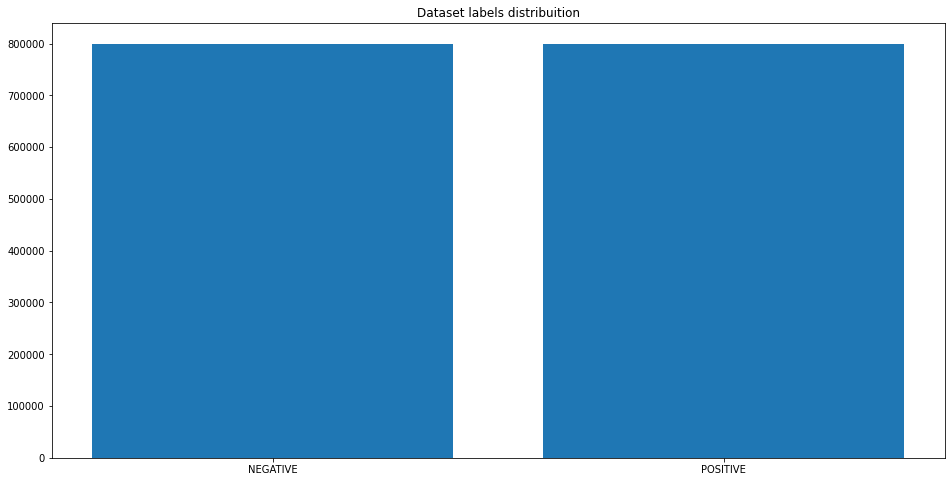

In [14]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

**Train Test Split**

In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


**Word2Vec**

In [16]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.75 s, sys: 321 ms, total: 3.07 s
Wall time: 3.07 s


In [17]:
print(documents[0:1])

[['ya', 'quot', 'like', 'palm', 'pre', 'touchstone', 'charger', 'readynow', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch']]


In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [19]:
w2v_model.build_vocab(documents)

In [20]:
words = w2v_model.wv.key_to_index
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [21]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 21min 52s, sys: 7.07 s, total: 21min 59s
Wall time: 11min 45s


(263121946, 295270528)

In [22]:
w2v_model.wv.most_similar("love") 

[('luv', 0.5709445476531982),
 ('loves', 0.5652464032173157),
 ('loved', 0.5340264439582825),
 ('adore', 0.5064412355422974),
 ('amazing', 0.4951012432575226),
 ('looove', 0.46974778175354004),
 ('awesome', 0.46866700053215027),
 ('lovee', 0.4612950384616852),
 ('loveee', 0.45681679248809814),
 ('loooove', 0.43337586522102356)]

**Tokenize the Text**

In [23]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 17.8 s, sys: 147 ms, total: 18 s
Wall time: 17.9 s


In [24]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text),
                        maxlen=SEQUENCE_LENGTH)

x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text),
                       maxlen=SEQUENCE_LENGTH)

CPU times: user 30 s, sys: 578 ms, total: 30.6 s
Wall time: 30.9 s


In [25]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

y_train:  (1280000, 1)
y_test:  (320000, 1)


In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)

(290419, 300)


In [28]:
embedding_layer = Embedding(vocab_size,
                            W2V_SIZE,
                            weights=[embedding_matrix],
                            input_length=SEQUENCE_LENGTH,
                            trainable=False)

**Build Model**

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2021-10-30 07:30:35.412786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 07:30:35.502485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 07:30:35.503249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 07:30:35.505272: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [31]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [32]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2021-10-30 07:30:38.610086: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1382400000 exceeds 10% of free system memory.
2021-10-30 07:30:39.693187: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8
1125/1125 [==============================] - 581s 514ms/step - loss: 0.5065 - accuracy: 0.7486 - val_loss: 0.4656 - val_accuracy: 0.7790
Epoch 2/8
1125/1125 [==============================] - 574s 510ms/step - loss: 0.4828 - accuracy: 0.7653 - val_loss: 0.4586 - val_accuracy: 0.7830
Epoch 3/8
1125/1125 [==============================] - 580s 516ms/step - loss: 0.4768 - accuracy: 0.7689 - val_loss: 0.4555 - val_accuracy: 0.7854
Epoch 4/8
1125/1125 [==============================] - 573s 509ms/step - loss: 0.4733 - accuracy: 0.7712 - val_loss: 0.4555 - val_accuracy: 0.7858
Epoch 5/8
1125/1125 [==============================] - 575s 511ms/step - loss: 0.4704 - accuracy: 0.7727 - val_loss: 0.4532 - val_accuracy: 0.7863
Epoch 6/8
1125/1125 [==============================] - 576s 512ms/step - loss: 0.4681 - accuracy: 0.7745 - val_loss: 0.4516 - val_accuracy: 0.7875
Epoch 7/8
1125/1125 [==============================] - 575s 511ms/step - loss: 0.4668 - accuracy: 0.7752 - val_loss: 0

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 26s 83ms/step - loss: 0.4492 - accuracy: 0.7893
ACCURACY: 0.7892781496047974
LOSS: 0.4492000937461853
CPU times: user 24.9 s, sys: 506 ms, total: 25.4 s
Wall time: 26.5 s


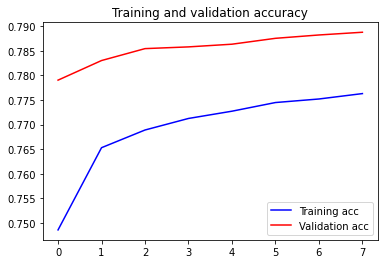

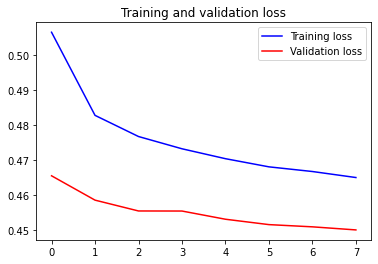

In [38]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(accuracy))
 
plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [39]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [40]:
def predict(text, include_neutral=True):
    start_at = time.time()
    
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]),
                           maxlen=SEQUENCE_LENGTH)
    
    score = model.predict([x_test])[0]
    
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, 
            "score": float(score),
            "elapsed_time": time.time() - start_at}

In [41]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9756836295127869,
 'elapsed_time': 0.3333921432495117}

In [42]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.01376677118241787,
 'elapsed_time': 0.1142122745513916}

In [43]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.3185729384422302,
 'elapsed_time': 0.11026525497436523}

In [44]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 14s 348ms/step
CPU times: user 11.3 s, sys: 4.25 s, total: 15.5 s
Wall time: 21.8 s


In [45]:
def plot_confusion_matrix(cm, 
                          classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

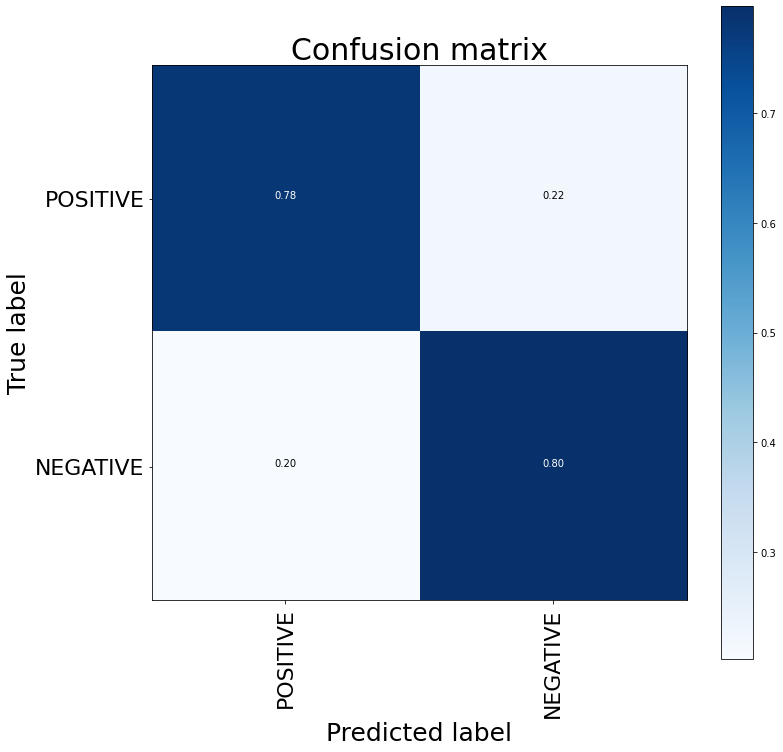

CPU times: user 1.6 s, sys: 142 ms, total: 1.74 s
Wall time: 1.61 s


In [46]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix,
                      classes=df_train.target.unique(),
                      title="Confusion matrix")

plt.show()

In [47]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [48]:
accuracy_score(y_test_1d, y_pred_1d)

0.789278125

In [49]:
model.save(KERAS_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [50]:
w2v_model.save(WORD2VEC_MODEL)